In [1]:
%matplotlib notebook
#%matplotlib inline

import copy
import numpy as np
import random
import matplotlib.pyplot as plt
from _converter import SensorThings2Dict
from _evaluation import print_metrics

In [2]:
import json
files = ["ABU1.txt"]#, "ABU1.2.txt"
data = []
bad = 0
for filename in files:
    print("Loading rows... {}".format(filename))
    with open(filename) as f:
        for line in f:
            try:
                features = SensorThings2Dict(json.loads(line))
                data.append(list(features.values()))
            except Exception, e:
                bad+=1

print("Incomplete rows: {}".format(bad))
print("Loaded: {}".format(len(data)))

""" random split seed """
data = np.asarray(data)
#print(data[:,2:-1])
# numerics = data[:,2:-1]
# for n in numerics[data[:,-1]=='True']:
#     plt.plot(n);
mask = np.random.rand(len(data)) < 0.9

Loading rows... ABU1.txt
Incomplete rows: 170
Loaded: 30768


In [3]:
train = data[mask]
test = data[~mask]
print("Train Total: {} Good: {} Faulty: {} Ratio: {}".format(len(train), len(train[train[:,-1]=='True']), len(train[train[:,-1]=='False']), float(len(train[train[:,-1]=='False']))/len(train)))
print("Test  Total: {} Good: {} Faulty: {} Ratio: {}".format(len(test), len(test[test[:,-1]=='True']), len(test[test[:,-1]=='False']), float(len(test[test[:,-1]=='False']))/len(train)))

Train Total: 27603 Good: 25986 Faulty: 1617 Ratio: 0.0585805890664
Test  Total: 3165 Good: 2997 Faulty: 168 Ratio: 0.00608629496794


In [4]:
faulty = train[train[:,-1]=='False']
not_faulty = train[train[:,-1]=='True']
# train = np.concatenate((not_faulty[:len(faulty)*5], faulty))
# samples = np.random.choice(len(not_faulty), 5000, replace=False)
# train = np.concatenate((not_faulty[samples], faulty))
# train = np.random.permutation(train)
print("Train Total: {} Good: {} Faulty: {} Ratio: {}".format(len(train), len(train[train[:,-1]=='True']), len(train[train[:,-1]=='False']), float(len(train[train[:,-1]=='False']))/len(train)))

train_data = train[:,2:-1].astype(np.float32)
test_data = test[:,2:-1].astype(np.float32)
"""
Quality_OK is mapped to Faultiness
    'False' -> 1 (Faulty)
    'True'  -> 0 (Good)
"""
train_labels = np.array(train[:,-1]=='False').astype(np.int32)
test_labels = np.array(test[:,-1]=='False').astype(np.int32)

Train Total: 27603 Good: 25986 Faulty: 1617 Ratio: 0.0585805890664


<IPython.core.display.Javascript object>


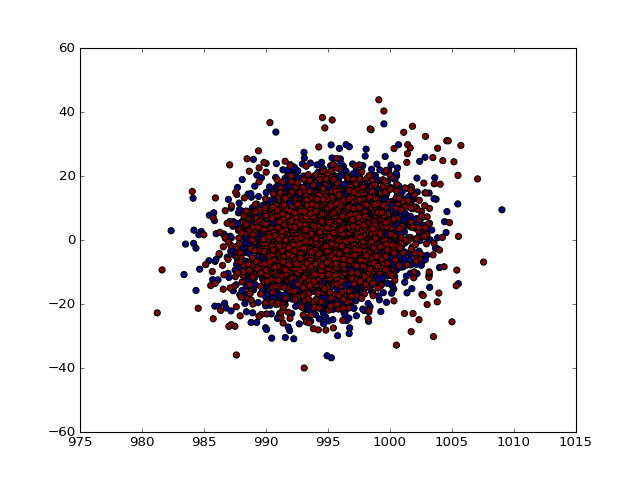

In [23]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
svd = TruncatedSVD(n_components=2, n_iter=100, random_state=1)
reduced = svd.fit_transform(train_data) 
#train_data = svd.transform(train_data)
#test_data = svd.transform(test_data)
# print(reduced)
plt.scatter(reduced[:,0],reduced[:,1], c=train_labels, s=30)

# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(reduced[:,0],reduced[:,1], reduced[:,2], c=train_labels, s=30)
# plt.show()

In [23]:
""" Classification and Regression Trees (CART) """
from sklearn.tree import DecisionTreeClassifier

# ratio = float(len(train[train[:,-1]=='False']))/len(train)
criteria = ["gini", "entropy"]
clf = DecisionTreeClassifier(criterion=criteria[0], random_state=1, max_depth=100,  class_weight={0:1.0, 1:0.05})

%time t = clf.fit(train_data, train_labels)

# print(clf.predict_proba(test_data[:,r]))
print_metrics(train_labels, clf.predict(train_data))
print_metrics(test_labels, clf.predict(test_data))

# from sklearn.tree import export_graphviz
# from subprocess import call
# export_graphviz(clf, out_file='treeT.dot', class_names=True) 
# call(["dot","-Tpng","treeT.dot","-o","treeT.png"])

Wall time: 7.43 s
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     26153
          1       1.00      0.98      0.99      1599

avg / total       1.00      1.00      1.00     27752

Confusion Matrix:


,0,1
0,26153,0
1,25,1574


Matthews Correlation Coefficient: 0.991677951302
--------------------------------------------------------------
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2830
          1       1.00      0.97      0.99       186

avg / total       1.00      1.00      1.00      3016

Confusion Matrix:


,0,1
0,2830,0
1,5,181


Matthews Correlation Coefficient: 0.985597291789
--------------------------------------------------------------


In [ ]:
# """ ExtraTreeClassifier """
# from sklearn.tree import ExtraTreeClassifier

# # ratio = float(len(train[train[:,-1]=='False']))/len(train)
# clf = ExtraTreeClassifier(max_depth=70)
# %time t = clf.fit(train_data, train_labels)

# eval_metrics(train_labels, clf.predict(train_data))
# eval_metrics(test_labels, clf.predict(test_data))

In [6]:
""" Random Forest """
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,  class_weight={0:1.0, 1:0.05}, max_depth=90, n_jobs=4)

%time clf = clf.fit(train_data, train_labels)
print_metrics(train_labels, clf.predict(train_data))
print_metrics(test_labels, clf.predict(test_data))

Wall time: 24.5 s
------------------------- EVALUATION -------------------------
Confusion Matrix:
[[25986     0]
 [   45  1572]]
Matthews Correlation Coefficient: 0.985134552808
--------------------------------------------------------------
------------------------- EVALUATION -------------------------
Confusion Matrix:
[[2996    1]
 [  10  158]]
Matthews Correlation Coefficient: 0.964936331636
--------------------------------------------------------------


In [13]:
""" Gradient Boosting """
from sklearn.ensemble import GradientBoostingClassifier

losses = ['deviance', 'exponential']
clf = GradientBoostingClassifier(loss=losses[0], n_estimators=100,  max_depth=15, learning_rate=0.1)

%time clf = clf.fit(train_data, train_labels)
print_metrics(train_labels, clf.predict(train_data))
print_metrics(test_labels, clf.predict(test_data))

Wall time: 43.6 s
------------------------- EVALUATION -------------------------
Confusion Matrix:
[[25986     0]
 [   10  1607]]
Matthews Correlation Coefficient: 0.996711298459
--------------------------------------------------------------
------------------------- EVALUATION -------------------------
Confusion Matrix:
[[2996    1]
 [   5  163]]
Matthews Correlation Coefficient: 0.981006833881
--------------------------------------------------------------


In [ ]:
import random
from copy import deepcopy
def randomPair(predicted_label):
    index = random.sample(np.where(train_labels==abs(1-predicted_label))[0],1)
    return deepcopy(train_data[index][0]), deepcopy(train_labels[index][0])

for i,t in enumerate(test_data):
    prediction = clf.predict([t])[0]
    pair_data, pair_label = randomPair(prediction)
#     print(test_data[i])
#     print(pair_data)
    clf = clf.fit([test_data[i],pair_data], [prediction,pair_label])

print_metrics(train_labels, clf.predict(train_data))
print_metrics(test_labels, clf.predict(test_data))

In [ ]:
""" Bagging Classifier """ 
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics

clf = BaggingClassifier(n_estimators=50, random_state=1)
%time clf = clf.fit(train_data, train_labels)

print_metrics(train_labels, clf.predict(train_data))
print_metrics(test_labels, clf.predict(test_data))

In [8]:
""" Random Forest """
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


clf = RandomForestClassifier(n_estimators=100,  class_weight={0:0.98, 1:0.02}, max_depth=90, n_jobs=4)
# clf = DecisionTreeClassifier(criterion="gini", random_state=1, max_depth=100,  class_weight={0:1.0, 1:0.05})

MCCs = []
HLs = []
ratio = 0.98/0.02
for tr in xrange(10,1720,100):
    small = np.concatenate((not_faulty[:tr*ratio], faulty[:tr]))
    small_data = small[:,2:-1].astype(np.float32)
    small_labels = np.array(small[:,-1]=='False').astype(np.int32)
    clf = clf.fit(small_data, small_labels)
    mcc = metrics.matthews_corrcoef(test_labels, clf.predict(test_data))
    hl = metrics.hamming_loss(test_labels, clf.predict(test_data))
    print("{}\t{}\t{}".format(tr, mcc, hl))
    MCCs.append(mcc)
    HLs.append(hl)

C:\Users\Farshid\Anaconda2\envs\python2\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


10	0.0	0.0583372697213
110	0.608257543799	0.03589985829
210	0.805045463597	0.0197213037317
310	0.918964402095	0.00862068965517
410	0.933799403687	0.00708549834672
510	0.95515087718	0.00484175720359
610	0.966238790391	0.00366084081247
710	0.969545792535	0.00330656589513
810	0.962922921488	0.00401511572981
910	0.964029202133	0.00389702409069
1010	0.967342105001	0.00354274917336
1110	0.960707369528	0.00425129900803
1210	0.967342105001	0.00354274917336
1310	0.968444437898	0.00342465753425
1410	0.978321820352	0.00236183278224
1510	0.971745580738	0.00307038261691
1610	0.972844021116	0.0029522909778
1710	0.965134490598	0.00377893245158


In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

clf = GradientBoostingClassifier(loss='exponential', n_estimators=100,  max_depth=90, learning_rate=0.1, subsample=1.0)

GBMCCs = []
GBHLs = []
for tr in xrange(10,1720,100):
    small = np.concatenate((not_faulty[:tr*10], faulty[:tr]))
    small_data = small[:,2:-1].astype(np.float32)
    small_labels = np.array(small[:,-1]=='False').astype(np.int32)
    clf = clf.fit(small_data, small_labels)
    mcc = metrics.matthews_corrcoef(test_labels, clf.predict(test_data))
    hl = metrics.hamming_loss(test_labels, clf.predict(test_data))
    print("{}\t{}\t{}".format(tr, mcc, hl))
    GBMCCs.append(mcc)
    GBHLs.append(hl)

10	0.0205375955848	0.090694378838
110	0.558179511355	0.0455833726972
210	0.728161726677	0.0289324515824
310	0.86962901672	0.0144071799717
410	0.910703232958	0.00980160604629
510	0.929336849701	0.00779404818139
610	0.940990074031	0.00661313179027
710	0.949028749607	0.00578649031649
810	0.960130530711	0.00448748228625
910	0.96938953794	0.00342465753425
1010	0.976631070782	0.00259801606046
1110	0.975468925119	0.00271610769957
1210	0.978700698998	0.00236183278224
1310	0.981875622968	0.0020075578649
1410	0.981927542518	0.0020075578649
1510	0.99033610101	0.00106282475201
1610	0.99140120371	0.000944733112896
1710	0.990317734025	0.00106282475201


<IPython.core.display.Javascript object>


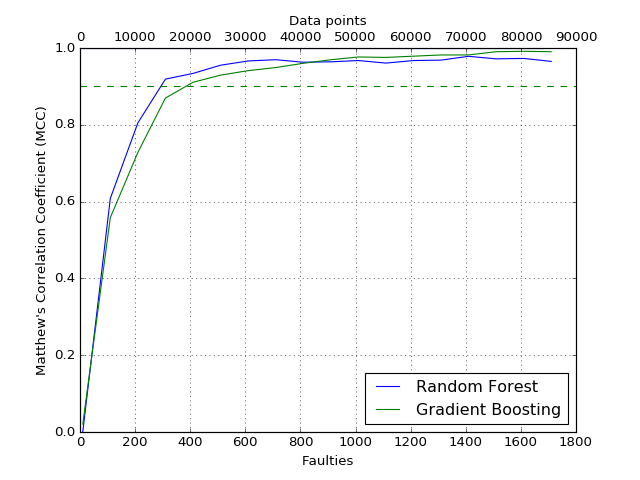

In [9]:
rrange = xrange(10,1720,100)
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.set_ylabel('Matthew\'s Correlation Coefficient (MCC)')
ax1.set_xlabel("Faulties")
p = ax1.plot(rrange,MCCs, label="Random Forest")
ax1.axhline(y=0.9, color='g', linestyle='dashed')
ax1.grid(True)
ax1.legend(loc=4)
# for xy in zip(rrange, MCCs):  
#     ax1.annotate("%.2f"%xy[1], xy=xy, textcoords='data')

ax3 = fig.add_subplot(111)
ax3.plot(rrange,GBMCCs, label="Gradient Boosting")
ax3.legend(loc=4)

ax2 = ax1.twiny()
ax2.cla()
ax2.set_xlabel('Data points')
ax2.plot(np.array(rrange)*49,np.ones(18))

plt.show()

<IPython.core.display.Javascript object>


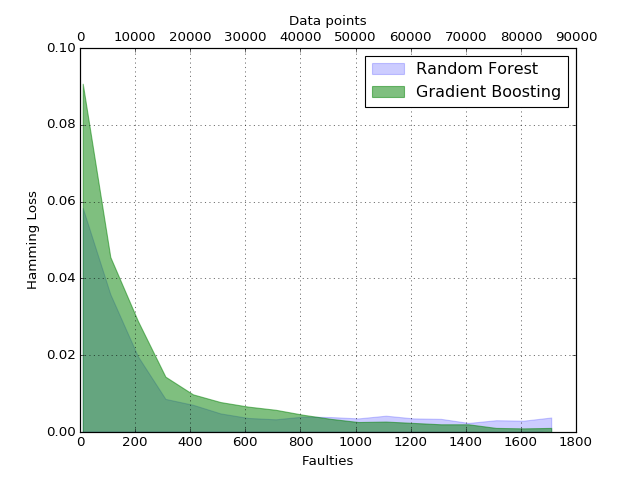

In [33]:
rrange = xrange(10,1720,100)
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.set_ylabel('Hamming Loss')
ax1.set_xlabel("Faulties")
# ax1.plot(rrange,MCCs)
# ax1.axhline(y=0.9, color='g', linestyle='dotted')
ax1.grid(True)
ax1.fill_between(rrange,HLs, alpha=0.2, color='b', label="Random Forest")
ax1.set_autoscaley_on(False)
ax1.set_ylim([0.0,0.1])

ax3 = fig.add_subplot(111)
ax3.fill_between(rrange,GBHLs, alpha=0.5, color='g', label="Gradient Boosting")
ax3.legend(loc=1)

ax2 = ax1.twiny()
ax2.cla()
ax2.set_xlabel('Data points')
ax2.plot(np.array(rrange)*49,np.zeros(18))

plt.show()

In [13]:
""" Random Forest """
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


clf = RandomForestClassifier(n_estimators=100,  class_weight={0:0.98, 1:0.02}, max_depth=90, n_jobs=4)
# clf = DecisionTreeClassifier(criterion="gini", random_state=1, max_depth=100,  class_weight={0:1.0, 1:0.05})

faulty = train[train[:,-1]=='False']
not_faulty = train[train[:,-1]=='True']

sMCCs = []
sHLs = []
ratio = 0.98/0.02
for tr in xrange(10,1720,100):
    small = np.concatenate((not_faulty[:], faulty[:tr]))
    small_data = small[:,2:-1].astype(np.float32)
    small_labels = np.array(small[:,-1]=='False').astype(np.int32)
    clf = clf.fit(small_data, small_labels)
    mcc = metrics.matthews_corrcoef(test_labels, clf.predict(test_data))
    hl = metrics.hamming_loss(test_labels, clf.predict(test_data))
    print("{}\t{}\t{}".format(tr, mcc, hl))
    sMCCs.append(mcc)
    sHLs.append(hl)

10	0.0	0.0601333650869
110	0.559159211043	0.0404858299595
210	0.768114247567	0.0238151940938
310	0.873309750404	0.013693736604
410	0.880541634423	0.0129792807811
510	0.904099535819	0.0105977613718
610	0.915358940512	0.00940700166706
710	0.939015231551	0.00690640628721
810	0.92513644803	0.00845439390331
910	0.935799793366	0.00726363419862
1010	0.929757424478	0.00797809002143
1110	0.9356220598	0.00738271016909
1210	0.932426502206	0.0077399380805
1310	0.937993466551	0.00714455822815
1410	0.949201324352	0.00595379852346
1510	0.940997844943	0.00690640628721
1610	0.938180624064	0.00726363419862
1710	0.915417141004	0.009645153608


In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

clf = GradientBoostingClassifier(loss='exponential', n_estimators=100,  max_depth=90, learning_rate=0.1, subsample=1.0)

sGBMCCs = []
sGBHLs = []
for tr in xrange(10,1720,100):
    small = np.concatenate((not_faulty[:], faulty[:tr]))
    small_data = small[:,2:-1].astype(np.float32)
    small_labels = np.array(small[:,-1]=='False').astype(np.int32)
    clf = clf.fit(small_data, small_labels)
    mcc = metrics.matthews_corrcoef(test_labels, clf.predict(test_data))
    hl = metrics.hamming_loss(test_labels, clf.predict(test_data))
    print("{}\t{}\t{}".format(tr, mcc, hl))
    sGBMCCs.append(mcc)
    sGBHLs.append(hl)

10	0.207179543829	0.0573946177661
110	0.739347811339	0.0263157894737
210	0.83178514555	0.0177423195999
310	0.885421669061	0.0125029768993
410	0.917983658992	0.00916884972613
510	0.920369060739	0.00893069778519
610	0.941474108245	0.00666825434627
710	0.948102823222	0.00595379852346
810	0.953984442917	0.00535841867111
910	0.956310673926	0.00512026673017
1010	0.956448896233	0.00512026673017
1110	0.952806314733	0.00559657061205
1210	0.954844805502	0.00535841867111
1310	0.954844805502	0.00535841867111
1410	0.95659043076	0.00512026673017
1510	0.956883296271	0.00512026673017
1610	0.953125940284	0.00559657061205
1710	0.956094751531	0.00523934270064


<IPython.core.display.Javascript object>


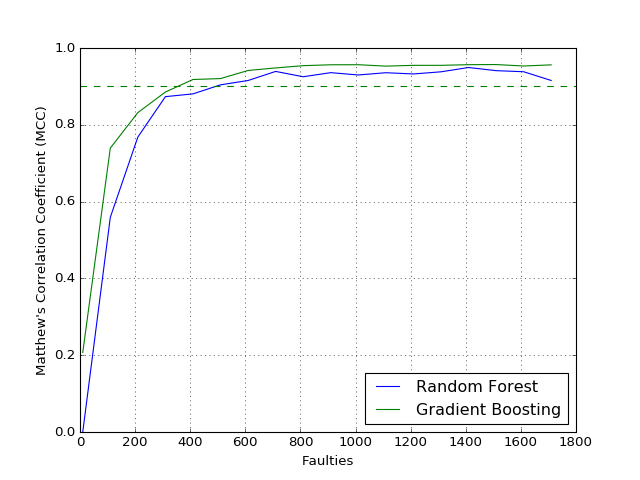

In [35]:
rrange = xrange(10,1720,100)
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.set_ylabel('Matthew\'s Correlation Coefficient (MCC)')
# ax1.set_xlabel('Positive samples (faulties)')
ax1.set_xlabel("Faulties")
p = ax1.plot(rrange,sMCCs, label="Random Forest")
ax1.axhline(y=0.9, color='g', linestyle='dashed')
ax1.grid(True)
ax1.legend(loc=4)

ax3 = fig.add_subplot(111)
ax3.plot(rrange,sGBMCCs, label="Gradient Boosting")
ax3.legend(loc=4)

plt.show()